In [3]:
import cv2
import os
import matplotlib.pyplot as plt 
import numpy as np


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [4]:

# Replace 'your_video_file.mp4' with the actual path to your video file
video_file_path = r'../videos_plateau_train_val/train.avi'

# Open the video file
cap = cv2.VideoCapture(video_file_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Set the desired window dimensions
window_width = 800
window_height = int(window_width * (frame_height / frame_width))

# Create a window with the desired dimensions
cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video', window_width, window_height)


# Define the coordinates of the rectangle
rect_start = (int(0.35 * window_width), int(0.5 * window_height))
rect_end = (int(0.55 * window_width), int(0.75 * window_height))

# Read and display the video frame by frame
while True:
    # Read a frame
    ret, frame = cap.read()

    # If the frame is not read successfully, break the loop
    if not ret:
        break

    # Resize the frame
    frame = cv2.resize(frame, (window_width, window_height))
    # Draw the rectangle on the frame
    cv2.rectangle(frame, rect_start, rect_end, (0, 255, 0), 2)  # Green rectangle


    # Display the frame
    cv2.imshow('Video', frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()

# Capture the image and put in a training dataset

In [16]:

# Replace 'your_video_file.mp4' with the actual path to your video file
video_file_path = r'../videos_plateau_train_val/val.avi'

# Define the coordinates of the rectangle
rect_start = (int(0.35 * 2448), int(0.5 * 2048))
rect_end = (int(0.55 * 2448), int(0.75 * 2048))

# Open the video file
cap = cv2.VideoCapture(video_file_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Initialize frame counter
frame_count = 0

# Read and crop each frame, and save it to the output folder
while True:
    # Read a frame
    ret, frame = cap.read()

    # If the frame is not read successfully, break the loop
    if not ret:
        break

    # Crop the frame within the rectangle
    cropped_frame = frame[rect_start[1]:rect_end[1], rect_start[0]:rect_end[0]]

    # Save the cropped frame to the output folder
    output_path = os.path.join('Image_data', f'frame_{frame_count}.png')
    cv2.imwrite(output_path, cropped_frame)

    # Increment frame counter
    frame_count += 1

    # Break the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()


# Training of the CNN model

## A 'train_data_generator' for automatic pre-processing of all the input images

In [6]:
# Set the paths to your training data folders
train_data_dir = 'Training_images'
# Set image size and batch size
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for data augmentation and resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Specify 'training' for the training split
)

# Create the validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation split
)

Found 58 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [ ]:
train_generator.index_generato

In [7]:
# Mapping of class names to class indices
class_indices = train_generator.class_indices

# Reverse the mapping to get class indices to class names
inverse_class_indices = {v: k for k, v in class_indices.items()}

# Number of samples belonging to each class in the training set
num_samples_per_class_train = {class_name: sum(train_generator.classes == class_idx) for class_idx, class_name in inverse_class_indices.items()}

# Number of samples belonging to each class in the validation set
num_samples_per_class_validation = {class_name: sum(validation_generator.classes == class_idx) for class_idx, class_name in inverse_class_indices.items()}

# Display the results
print("Number of samples per class in the training set:")
print(num_samples_per_class_train)

print("\nNumber of samples per class in the validation set:")
print(num_samples_per_class_validation)

Number of samples per class in the training set:
{'images_with_puck': 28, 'images_without_puck': 30}

Number of samples per class in the validation set:
{'images_with_puck': 7, 'images_without_puck': 7}


### Visualizing the images after slight augmentation

Images belonging to 'rondelle'  : Label=0 \
Images NOT belonging to 'rondelle'  : Label=1

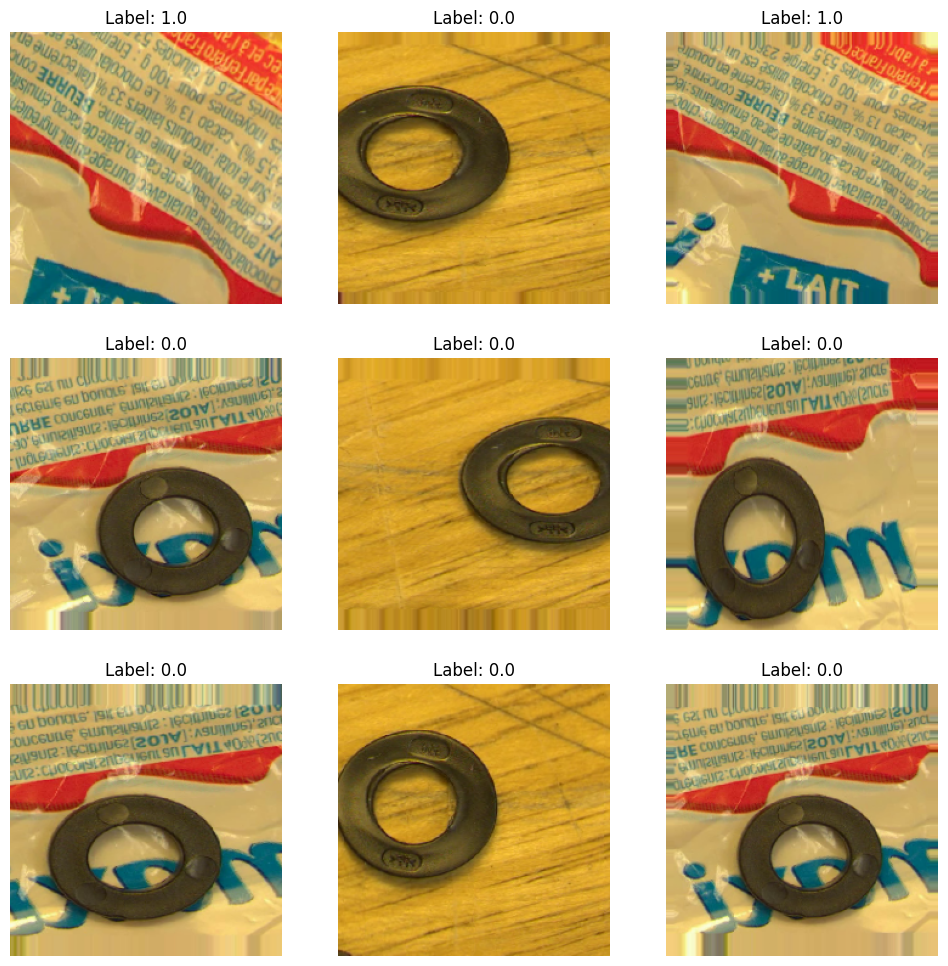

In [8]:

# Function to plot images
def plot_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Load a batch of images from the training generator
sample_images, sample_labels = next(train_generator)

# Display the images
plot_images(sample_images, sample_labels)

## Transfer learning with a pre-trained Mobile-net model with imagenet weights

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
)

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=100,  # You can adjust the number of epochs
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Save the model
model.save('binary_classification_model.h5')

Epoch 1/100
2/2 [==============================] - 28s 15s/step - loss: 0.5733 - accuracy: 0.7586 - val_loss: 0.1691 - val_accuracy: 1.0000
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 0.1541 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 3s 2s/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 3s 2s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 6/100
2/2 [==============================] - 3s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 3s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 9.7970e-04 - val_accuracy: 1.0000
Epoch 8/100
2/2 [===========

c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [112]:
# from tensorflow.keras import layers, models

# # Define the EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',  # Monitor validation accuracy
#     patience=20,  # Number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
# )

# # Create a simple CNN model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=100,  # You can adjust the number of epochs
#     validation_data=validation_generator,
#     callbacks=[early_stopping]
# )

# # Save the model
# model.save('binary_classification_model.h5')


## Display the predictions using the trained neural network

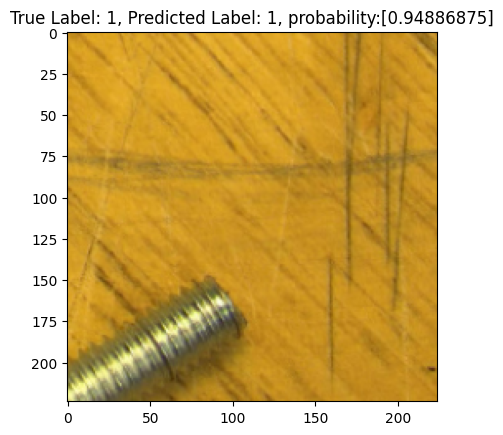

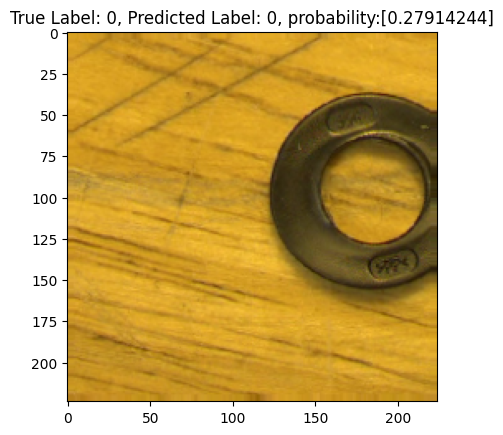

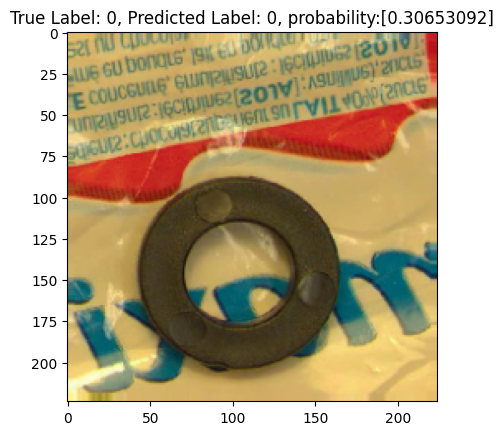

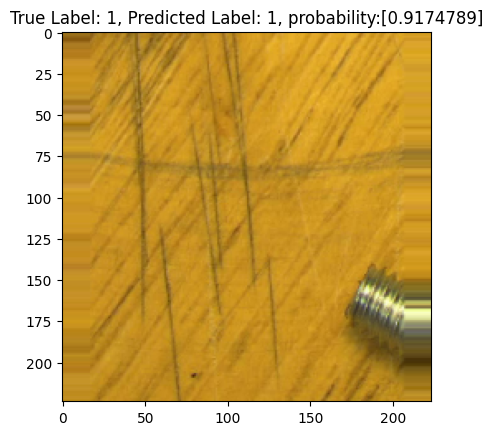

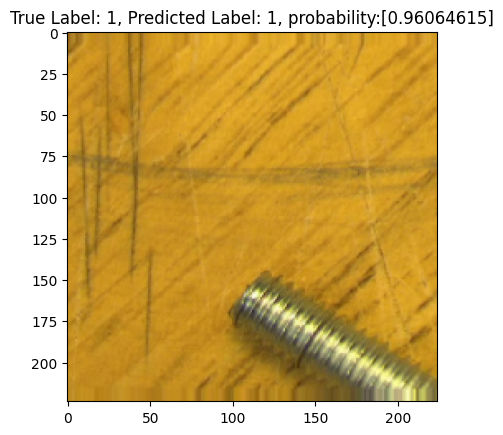

In [10]:
# Load the trained model
model = tf.keras.models.load_model('binary_classification_model.h5')


# Extract images and true labels from the batch
images, true_labels = train_generator.next()

# Predict the labels using the model
predicted_labels = model.predict(images)

# Convert predicted labels to binary (0 or 1) based on a threshold (e.g., 0.5)
predicted_labels_binary = np.round(predicted_labels)

# Display a sample of images with true and predicted labels
num_samples_to_display = 5
for i in range(num_samples_to_display):
    plt.imshow(images[i])
    plt.title(f'True Label: {int(true_labels[i])}, Predicted Label: {int(predicted_labels_binary[i])}, probability:{predicted_labels[i]}')
    plt.show()

# Reatime prediction

In [114]:
# Load the pre-trained CNN model
model = load_model('binary_classification_model.h5')

# Replace 'your_video_file.mp4' with the actual path to your video file
video_file_path = r'videos_plateau_train_val/val.avi'

# Open the video file
cap = cv2.VideoCapture(video_file_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Set the desired window dimensions
window_width = 800
window_height = int(window_width * (frame_height / frame_width))

# Create a window with the desired dimensions
cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video', window_width, window_height)

# Define the coordinates of the rectangle
rect_start = (int(0.35 * window_width), int(0.5 * window_height))
rect_end = (int(0.55 * window_width), int(0.75 * window_height))

# Read and display the video frame by frame
while True:
    # Read a frame
    ret, frame = cap.read()

    # If the frame is not read successfully, break the loop
    if not ret:
        break

    # Resize the frame
    frame = cv2.resize(frame, (window_width, window_height))

    # Crop the region inside the rectangle
    cropped_region = frame[rect_start[1]:rect_end[1], rect_start[0]:rect_end[0]]

    # Preprocess the cropped region and make a prediction
    cropped_region = cv2.resize(cropped_region, (224, 224))
    cropped_region = cropped_region / 255.0  # Normalize pixel values
    cropped_region = np.expand_dims(cropped_region, axis=0)  # Add batch dimension
    prediction = model.predict(cropped_region)[0, 0]

    # Update the rectangle color based on the prediction
    if prediction < 0.4:
        rect_color = (0, 255, 0)  # Green rectangle for 0 output
    else:
        rect_color = (0, 0, 255)  # Red rectangle for 1 output

    # Draw the rectangle on the frame
    cv2.rectangle(frame, rect_start, rect_end, rect_color, 2)

    # Display the prediction value near the rectangle
    cv2.putText(frame, f'Prediction: {prediction:.4f}', (rect_start[0], rect_start[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()
